In [1]:
%load_ext autoreload
%autoreload 2

# Deep learning tips and tricks: Data augmentation and Transfer learning

**What you will learn today**: You will learn how to improve the performance of a deep neural network by increasing the effective data available for training using data augmentation. You will also learn how to leverage large pretrained models to boost the performance of a downstream task using transfer learning.

## On the previous episode...

On the previous lab we explored different techniques to train neural networks and implemented them using `PyTorch`. Our experiments showed that choosing the right learning rate and architecture are fundamental to generalize on a complex dataset such as CIFAR10. We learned how modern optimizers work, and explored new architectural concepts such as batch normalization and skip connections.

In this lab, we will continue this journey and investigate other techniques to improve performance of a neural network. In particular, we will see how one can exploit the flexibility of stochastic gradient descent to increase our effective data available, and how we can leverage large pretrained models to initialize our networks in a smart way.

Specifically, we will talk about:
* Data augmentation
* Transfer learning

So... let's get started!


For convenience, we copy-paste the necessary code from the previous lab.

For every model we want to create, we will create a new class that inherits `BasicModel` and implemements the `__init__` and `forward` functions.

# Data augmentation
Data augmentation is a training technique which consists in transforming every batch of data shown to the model using some random operation which generates a new ''view'' of each sample that retains its semantic information. For example, in the context of image classification, the label of most objects remains the same if you mirror them horizontally. Therefore, a cheap way to increase your training data, is to ''augment'' each sample by introducing its mirrored counterpart.

Let's do it!

In [2]:
# first we load all the necessary libraries
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

from training_utils import fit, predict, plot_loss, visualize_images

In `PyTorch`, the data augmentation operations are included in the transformation pipeline of a dataset. You can find more details on the [official documentation](https://pytorch.org/vision/stable/transforms.html).

In [3]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip() # We want to randomly apply a random flip to every sample
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=test_transform)


100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In `PyTorch`, any `nn.Module` can be included in a transform pipeline. Every time you ask for a sample `x`, `PyTorch` calls `transform.forward(x)` before feeding it to the model. This means we can easily visualize the effect of data augmentation.

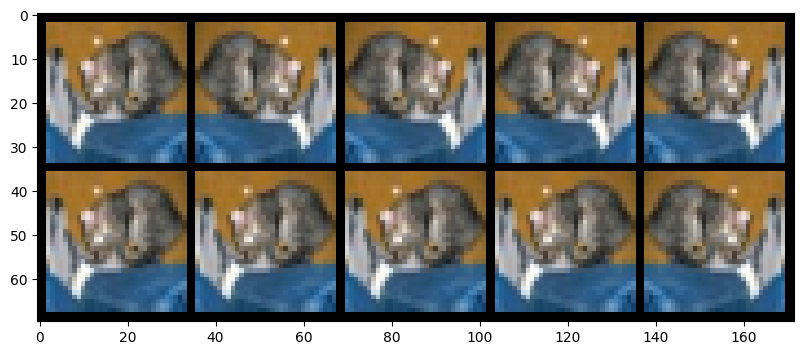

In [4]:
im, _ = test_dataset[0]
im = im[None, ...] # We need a leading batch dimension to feed to the model

images_rot = torch.cat([T.RandomHorizontalFlip()(im) for _ in range(10)])

grid = torchvision.utils.make_grid(images_rot, nrow=5, padding=2)
# Just normalization for test data
plt.figure(figsize=(20,4))
plt.imshow(grid.permute([1,2,0]))

Horizontal flips are a bit obvious. We can get more creative with data augmentation. However, bare in mind that some transformations might destroy important information of your data, so be careful when applying it.

CIFAR10 is relatively easy, so the following transformations are enough to achieve good performance.

In [5]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=[32,32], padding=4)
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=test_transform)

# we make the Batch_sizes smaller for computational reasons
# we will later use larger models and memory might become an issue
BATCH_SIZE = 256

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Let's train a **ResNet**! Since it is a standard model, it is already implemented in the `torchvision` library and we can use it directly.

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


Epoch 0: Loss=1.909949713215536
Epoch 1: Loss=1.5136435986781607
Epoch 2: Loss=1.2809773014516246
Epoch 3: Loss=1.101595182808078
Epoch 4: Loss=0.992489084297297
Epoch 5: Loss=0.9177786926833951
Epoch 6: Loss=0.8504907884159867
Epoch 7: Loss=0.7891675766025271
Epoch 8: Loss=0.7459775534819584
Epoch 9: Loss=0.7149199396371841
Epoch 10: Loss=0.6756729567233397
Epoch 11: Loss=0.6451339934553418
Epoch 12: Loss=0.6179438713861971
Epoch 13: Loss=0.6015727533673754
Epoch 14: Loss=0.5785561723976719
Epoch 15: Loss=0.5634637097923123
Epoch 16: Loss=0.5407393272129857
Epoch 17: Loss=0.5250498050329636
Epoch 18: Loss=0.5108731860408977
Epoch 19: Loss=0.4980978819788719
Epoch 20: Loss=0.48718975712450185
Epoch 21: Loss=0.47766268344558016
Epoch 22: Loss=0.4610629191203993
Epoch 23: Loss=0.45483239648901685
Epoch 24: Loss=0.44542061446272596
Epoch 25: Loss=0.4285357967019081
Epoch 26: Loss=0.4119880602371936
Epoch 27: Loss=0.40905416148657703
Epoch 28: Loss=0.39974964592529805
Epoch 29: Loss=0.3927

(0.6883492216587067, tensor(77.8200, device='cuda:0'))

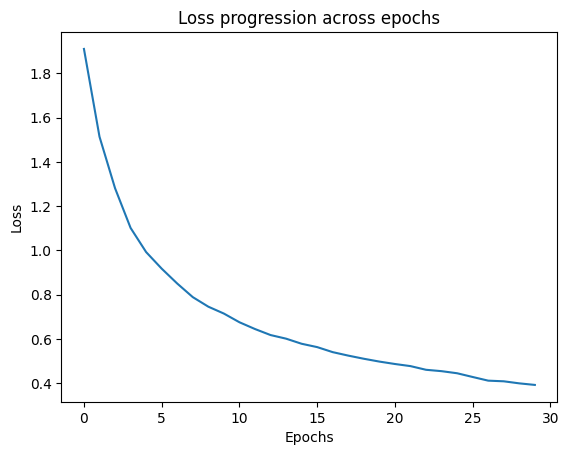

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.resnet import resnet18

model = resnet18(num_classes=10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
    )
)

# predict with the trained model
predict(
        model,
        test_dataloader = test_dataloader,
        device = DEVICE,
    )

# Transfer learning

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Transfer learning refers to the concept of initializing a neural network using the weights learned on a different task before training. Surprisingly, if the pretraining dataset is large enough, but also semantically ''close'' to the downstream task, using transfer learning, instead of regular training from random weights can significantly boost performance. Intuitively, transfer learning allows to recycle the features learned with a lot of data on the pretraining task, and leverage them to classify a new dataset.

Let's see this in practice. To that end, we will follow the [PyTorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which is an excellent resource to learn how to implement advanced techniques in deep learning. We will minimally adapt the code to fit our streamlined API from the previous labs.

Let's download our data...

In [8]:
import requests
import os

remote_url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'

local_file = './data/hymenoptera_data.zip'
os.makedirs('./data', exist_ok=True)

data = requests.get(remote_url)

# Save file data to local copy
with open(local_file, 'wb')as file:
    file.write(data.content)

and extract it...

In [9]:
from zipfile import ZipFile

# opening the zip file in READ mode
with ZipFile(local_file, 'r') as zip:
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall('./data')
    print('Done!')

Extracting all the files now...
Done!


We can work with this data directly using `torchvision`

In [10]:
# Data augmentation and normalization for training
# The normalization values are the average and std of each channel, precomputed
# on the training images
train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for test data
test_transform =  T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    # Should we add the same normalization for test as we did for train? Explain.
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


data_dir = 'data/hymenoptera_data'
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), test_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

train_size = len(train_dataset)
test_size = len(test_dataset)
class_names = train_dataset.classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Let's visualize a few images

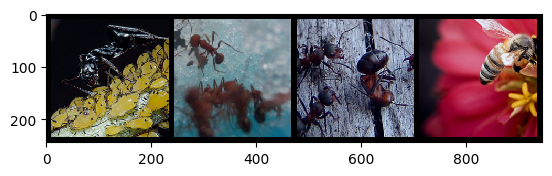

In [11]:
visualize_images(
    train_dataloader,
    mean=torch.tensor([0.485, 0.456, 0.406]),
    std=torch.tensor([0.229, 0.224, 0.225]),
)

There are two major transfer learning techniques depending on which parts of the network are updated using the new data:
1. Finetuning the full network
2. Finetuning only the last layer

First let's see how a randomly initialized model performs!

Epoch 0: Loss=0.8596883352662696
Epoch 1: Loss=0.7375968772856916
Epoch 2: Loss=0.7401212326815871
Epoch 3: Loss=0.6712842920764548
Epoch 4: Loss=0.8478293115975427
Epoch 5: Loss=0.7493889624955224
Epoch 6: Loss=0.7630657131066088
Epoch 7: Loss=0.8149208895495681
Epoch 8: Loss=0.6836484394601134
Epoch 9: Loss=0.745278955727327
Epoch 10: Loss=0.7278459361586415
Epoch 11: Loss=0.7374393117965244
Epoch 12: Loss=0.6102055328302696
Epoch 13: Loss=0.6707713567331189
Epoch 14: Loss=0.6353899821883342
Epoch 15: Loss=0.6442364043876773
Epoch 16: Loss=0.6326254347308737
Epoch 17: Loss=0.7297749591411137
Epoch 18: Loss=0.6608757918975392
Epoch 19: Loss=0.6469818615033979
Epoch 20: Loss=0.6731458079130923
Epoch 21: Loss=0.6576687573898033
Epoch 22: Loss=0.664513421840355
Epoch 23: Loss=0.6075124852969999
Epoch 24: Loss=0.6458408996218541
Test set: Avg. loss: 0.8978, Accuracy: 91/153 (59%)


(0.897801535532755, tensor(59.4771, device='cuda:0'))

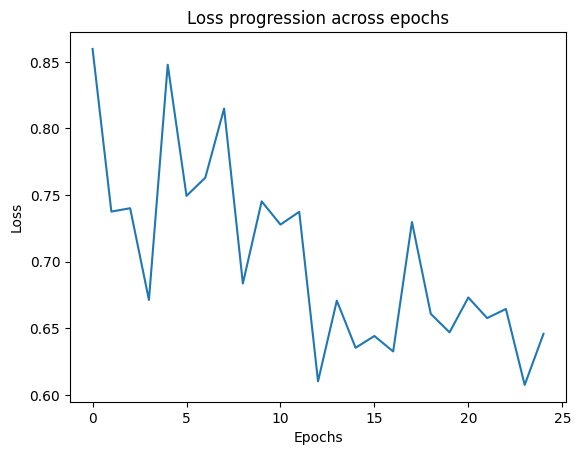

In [12]:
# the model is a resnet18. How many outputs should it have?
model = resnet18(num_classes=2).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the full network
Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. The rest of the training looks as usual, albeit normally using a significantly smaller learning rate.


In [ ]:
import torch.nn as nn

class FinetuningFullModel(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        # load pretrained resnet18
        self.network = ...
        # change the last layer with a randonly initializied one and with `num_classes` number of output neurons.
        ...

    def forward(self, x):
        return self.network(x)

Let's train it...

In [ ]:
model = FinetuningFullModel(num_classes=...).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the last layer

Sometimes finetuning all the parameters of a large model is too expensive, or unstable. In those cases, one can alternatively 'freeze' some parts of the network, and train only the latter parts. Most often, just tuning the last layer is enough to get good enough results, with the optimal performance normally achieved by finetuning a few of the last layers.

In [23]:
import torch.nn as nn

class FinetuningLastLayer(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        # load pretrained resnet18
        self.network = torchvision.models.resnet18(pretrained=True)

        # freeze the parameters of the network.
        for param in self.network.parameters():
            param.requires_grad = False

        # replace the last layer with a randonly initializied one and with `num_classes` number of output neurons.
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.network(x)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0: Loss=1.407536140719398
Epoch 1: Loss=0.5592005489791025
Epoch 2: Loss=0.6326777283560301
Epoch 3: Loss=0.6886192688977987
Epoch 4: Loss=0.45021083915880955
Epoch 5: Loss=0.44320720659385693
Epoch 6: Loss=0.5392396428515432
Epoch 7: Loss=0.31869681173416436
Epoch 8: Loss=0.39241199280120065
Epoch 9: Loss=0.544597107382705
Epoch 10: Loss=0.5969888905891538
Epoch 11: Loss=0.4241819270336848
Epoch 12: Loss=0.5101450036554673
Epoch 13: Loss=0.38142685306289037
Epoch 14: Loss=0.3536826480546447
Epoch 15: Loss=0.41740960086558443
Epoch 16: Loss=0.3727373969244969
Epoch 17: Loss=0.42113647566627344
Epoch 18: Loss=0.35727430315932535
Epoch 19: Loss=0.4956470874508415
Epoch 20: Loss=0.4485787807326367
Epoch 21: Loss=0.40802014745832954
Epoch 22: Loss=0.4917769524169567
Epoch 23: Loss=0.33461890266215827
Epoch 24: Loss=0.3194981420672209
Test set: Avg. loss: 0.2245, Accuracy: 143/153 (93%)


(0.22454082859327007, tensor(93.4641, device='cuda:0'))

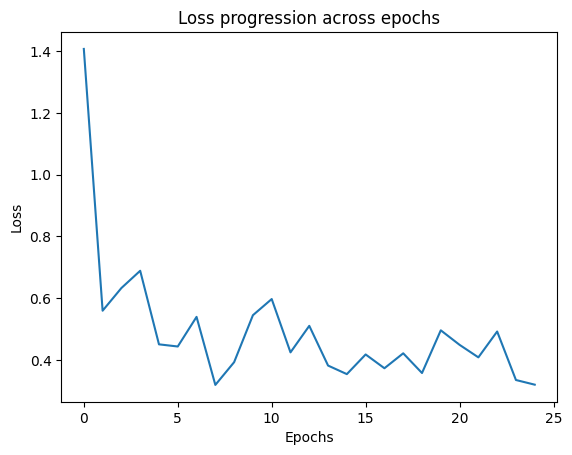

In [24]:
model = FinetuningLastLayer(num_classes=1000).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)